### 참고한 사이트
https://meissa.tistory.com/78

In [1]:
## 필요한 라이브러리 로드

import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

c:\ProgramData\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [9]:
## albumentations 라이브러리를 사용해 이미지 데이터 증강을 정의한 함수
## 테스트용 데이터는 증강하지 않음 -> 모델의 평가를 위해 이미지 크기만 일정하게 맞춤

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행
                Resize(
                    width=224,
                    height=224
                    )
                ])

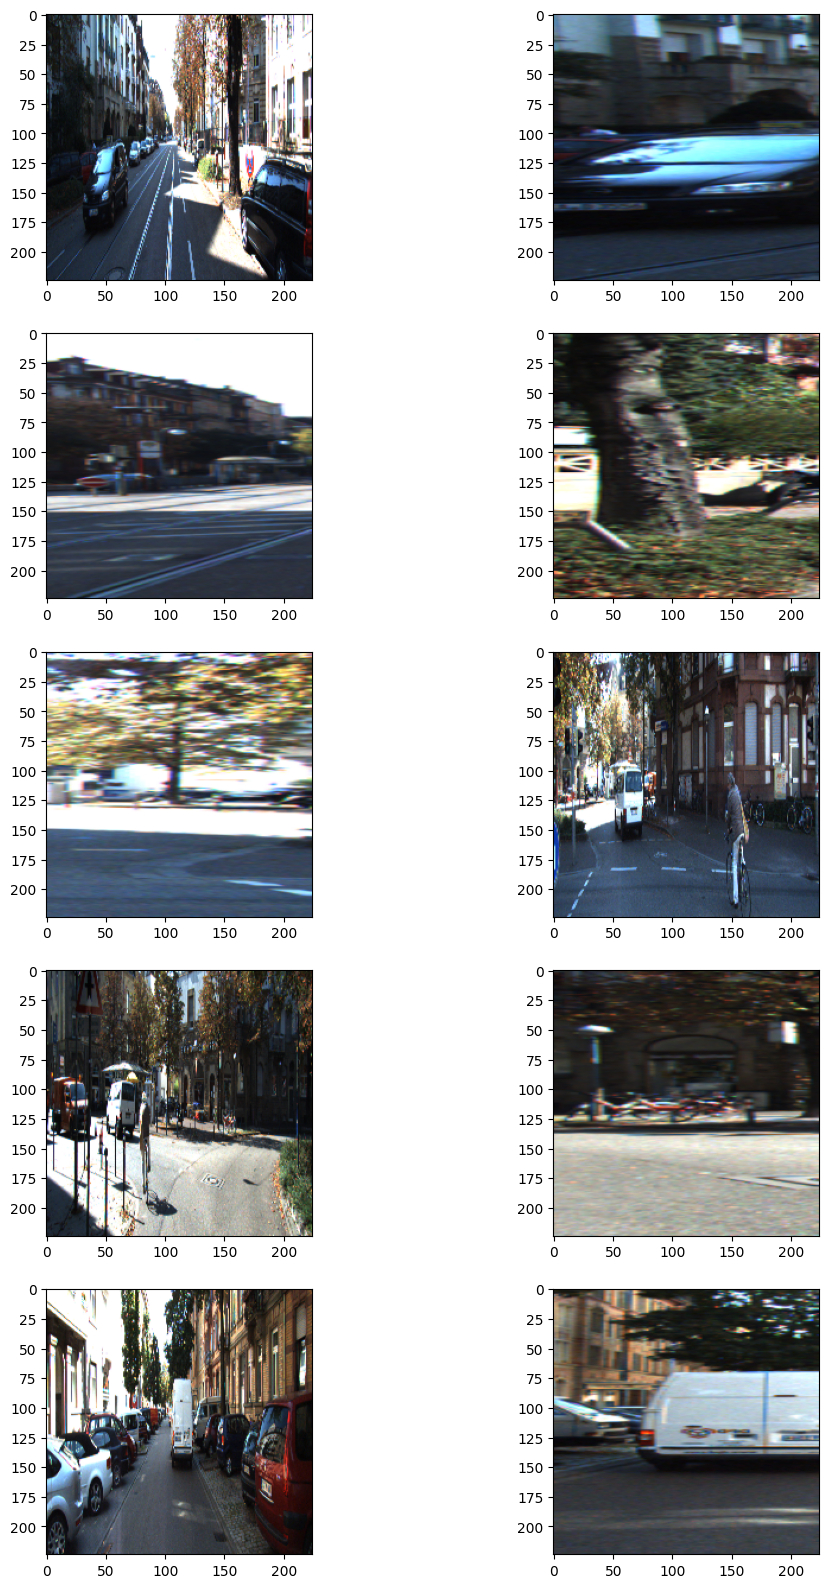

In [12]:
## 데이터에 직접 데이텉 증강을 적용하고 원본 이지미와 증강이 적용된 이미지를 시각화

dir_path = './data/training'  ## 이미지가 저장되어 있는 디렉토리 경로 지정

augmentation = build_augmentation()  ## 위 셀에서 만들어놓은 함수 호출하고 객체 생성
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))  ## 지정된 디렉토리 내에 모든 PNG 파일의 경로를 리스트로 부름
## glob(): 모듈 / 파일 시스템에서 특정 패턴에 맞는 파일 목록을 찾을 때 사용되는 Python 라이브러리

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))  ## 이미지를 표시할 그래프의 크기를 설정

for i in range(5):
    ## 이미지 파일 읽어오기
    image = imread(input_images[i])

    ## 증강 함수에 전달을 위해 이미지 데이터를 딕셔너리 형태로 준비
    image_data = {"image":image}

    ## 테스트용 데이터는 이미지의 크기만 조정
    resized = augmentation(**image_data, is_train=False)
    ## 훈련 데이터에는 증강도 함께 적용
    processed = augmentation(**image_data)
    
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [14]:
##  KITTI 데이터셋을 위한 데이터 제너레이터 클래스 KittiGenerator를 정의
## 데이터 로딩, 전처리, 증강(augmentation) 및 배치 생성 기능을 제공하여 딥러닝 모델 학습에 활용됨

## tf.keras.utils.Sequence를 상속받음
class KittiGenerator(tf.keras.utils.Sequence):

  ## 클래스 정의 및 초기화 메서드
  def __init__(self, 
               dir_path,  ## 데이터셋 위치한 디렉토리 경로
               batch_size=16,  ## 배치 크기 지정
               img_size=(224, 224, 3),  ## 입력 이미지 크기
               output_size=(224, 224),  ## 출력 크기
               is_train=True,  
               augmentation=None):
  
    ## 데이터셋 로드
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()

    ## 이미지와 라벨 개수 일지 확인
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    ## 훈련 데이터와 검증 데이터 분리
    if self.is_train:
      return data[:-30]  ## 마지막 30개를 제외한 모든 데이터를 훈련용으로 사용
    return data[-30:]  ## 마지막 30개 데이터를 검증용으로 사용
  
  ## 배치 처리를 위한 총 배치 수를 계산
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  ## 주어진 인덱스에 해당하는 배치 데이터 생성
  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1  ## 예: 클래스 7에 해당하는 픽셀을 1로 설정
      
      data = {
          "image": _input,
          "mask": _output,
          }
      
      ## 데이터 증강 적용
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  ## 에폭 종료 시 호출되는 함수
  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

### 모델 구조 만들기

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam

def build_model(input_shape=(224, 224, 3)):

  ## 모델의 입력층 정의
  inputs = Input(input_shape)

  ## Contracting Path -> 이미지 특징 추출
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

  ## Expanding Path -> 세밀한 로컬라이제이션을 위한 구성
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  
  up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  
  up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  
  up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  
  ## 최종 레이어에 1 x 1 컨볼루션 레이어 사용
  ## 최종적으로 판단할 클래스의 개수가 2개이기 때문에 채널의 개수를 2개로 줄이기 위함
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

### 모델 학습

In [32]:
## 모델 객체 생성
unet = build_model()

## 모델 컴파일
## 옵티마이저: Adam
## 학습률: 0.0001
## 손실 함수: binary_crossentropy
unet.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy')

## 모델 학습
unet.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),  ## 한 에폭 당 스텝 수 설정
     epochs=5,
 )



C:\Users\cutad\AppData\Local\Temp\ipykernel_21060\3552010405.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  unet.fit_generator(


Epoch 1/5
11/11 [==============================] - 271s 25s/step - loss: 0.7070 - val_loss: 0.6527
Epoch 2/5
11/11 [==============================] - 210s 19s/step - loss: 0.2852 - val_loss: 0.0435
Epoch 3/5
11/11 [==============================] - 222s 20s/step - loss: 0.0299 - val_loss: 0.0256
Epoch 4/5
11/11 [==============================] - 252s 24s/step - loss: 0.0280 - val_loss: 0.0266
Epoch 5/5
11/11 [==============================] - 231s 21s/step - loss: 0.0240 - val_loss: 0.0229


In [5]:
model_path = dir_path + '/unet.h5'
unet.save(model_path)  #학습한 모델을 저장해 주세요.

NameError: name 'unet' is not defined

### 모델 시각화

In [6]:
print(repr(model_path))

'./data/training/unet.h5'


In [43]:
import sys
print(sys.getdefaultencoding())  # 현재 기본 인코딩 출력

utf-8


In [7]:
x = tf.keras.models.load_model(model_path)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8c in position 20: invalid start byte

In [45]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

In [46]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [47]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [48]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 2   # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.000000


0.0

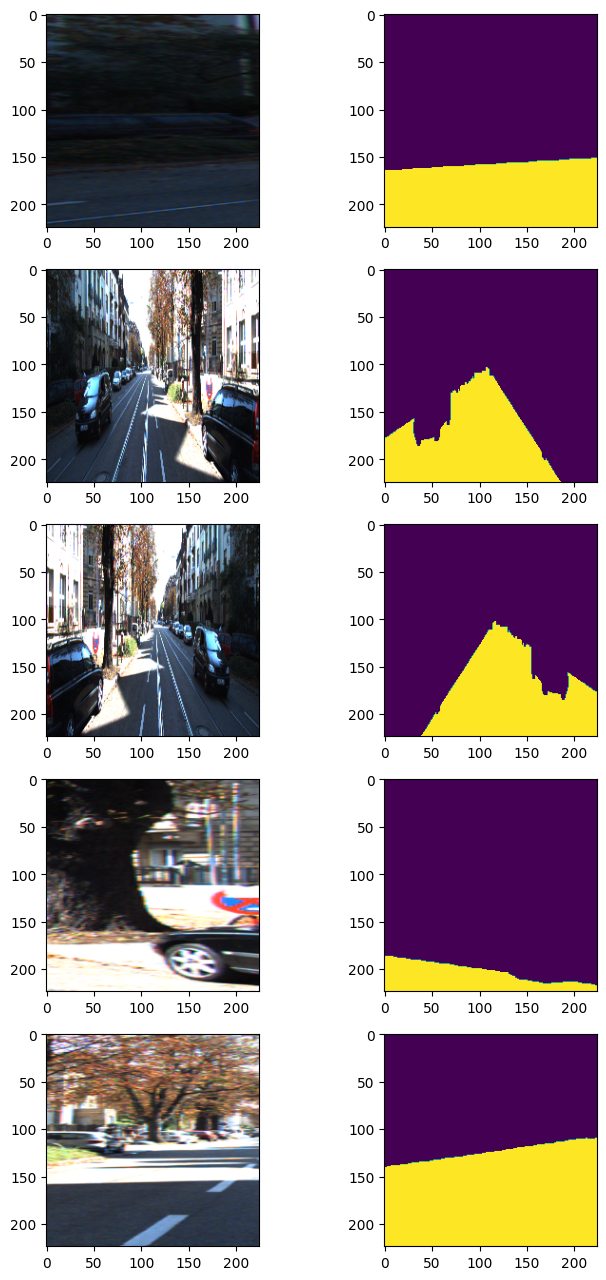

In [49]:
plt.figure(figsize=(8, 16))
for i in range(5) :
    data = next(iter(train_generator))
    
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(data[0][0, :, :])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(data[1][0, :, :])
plt.show()